# Setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from typing import List, Tuple

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

# Data Loading

In [2]:
TRAIN_DATA = 'norm_train.csv'
VAL_DATA = 'norm_val.csv'
TEST_DATA = 'norm_test.csv'

In [3]:
norm_train = pd.read_csv(TRAIN_DATA)
norm_val = pd.read_csv(VAL_DATA)
norm_test = pd.read_csv(TEST_DATA)

# Data Windowing

A window is a sample of the data that consists of consecutive time steps. For the purposes of training, we take two consecutive sub-samples from each window. The input data is taken from the first sub-sample and the labels from the second sub-sample. Call the first sub-sample the _input window_ and the second sub-sample as the _labels window_. The idea then is to train the model on the input window to predict the labels from the labels window. This corresponds to what we want in practice: given the weather data for the last so-many days, predict the weather for the next so-many days. Note that the input and labels window may not be flush with each other, that is, there may be a time gap between them.

The main features of a window are:

1. the number of time steps in the input and labels windows
2. the time offset between the input and label windows
3. which features are used as inputs/labels

In [4]:
class WindowGenerator():
    def __init__(self,
                 input_width: int,
                 label_width: int,
                 offset: int,
                 train_df: pd.DataFrame,
                 val_df: pd.DataFrame,
                 test_df: pd.DataFrame,
                 label_columns: List[str]):
        # Store raw data
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df

        # Store column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: idx for idx, name in enumerate(label_columns)}

        self.column_indices = {name: idx for idx, name in enumerate(train_df.columns)}

        # Window size params
        # offset = number of time steps after the input_width till the end of the label_width
        self.input_width = input_width
        self.label_width = label_width
        self.offset = offset

        self.total_window_size = input_width + offset

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

    def split_window(self, features: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """
            features is a tensor of rank 3: (batches, time steps, features)

            Returns a tuple consisting of the (inputs, labels)
        """
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]

        if self.label_columns is not None:
            # stack on the last axis
            labels = tf.stack([labels[:, :, self.column_indices[name]]
                               for name in self.label_columns],
                              axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data_frame: pd.DataFrame):
        # df_values = np.array(data_frame, dtype=np.float64)
        df_values = data_frame.to_numpy(dtype=np.float64)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=df_values,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=32)

        ds = ds.map(self.split_window)
        print("success! finished making dataset")
        return ds

    @property
    def make_train(self):
        return self.make_dataset(self.train_df)

    @property
    def make_val(self):
        return self.make_dataset(self.val_df)

    @property
    def make_test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.make_train))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = next(iter(self.make_train))
        print(f'Shape of inputs = {inputs.shape}; shape of labels: {labels.shape}')
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        plt.show()

## Testing Out the Window Generator 

In [5]:
def test():
    norm_train = pd.read_csv('norm_train.csv')
    norm_test = pd.read_csv('norm_test.csv')
    norm_val = pd.read_csv('norm_val.csv')

    w2 = WindowGenerator(input_width=6,
                         label_width=1,
                         offset=1,
                         label_columns=['T (degC)'],
                         train_df=norm_train,
                         val_df=norm_val,
                         test_df=norm_test)
    print('Window w2')
    print(w2)
    for example_inputs, example_labels in w2.make_train.take(2):
        print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
        print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [6]:
test()

Window w2
Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']
success! finished making dataset
Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [7]:
my_df = pd.DataFrame({'A': [1, 2, 3, 4, 5, 6], 'B': [2, 4, 6, 8, 10, 12]})
win = WindowGenerator(input_width=3,
                         label_width=1,
                         offset=1,
                         label_columns=['B'],
                         train_df=my_df,
                         val_df=my_df,
                         test_df=my_df)
train = win.make_train

for inp, lab in train:
    print(inp, lab)

success! finished making dataset
tf.Tensor(
[[[ 1.  2.]
  [ 2.  4.]
  [ 3.  6.]]

 [[ 2.  4.]
  [ 3.  6.]
  [ 4.  8.]]

 [[ 3.  6.]
  [ 4.  8.]
  [ 5. 10.]]], shape=(3, 3, 2), dtype=float64) tf.Tensor(
[[[ 8.]]

 [[10.]]

 [[12.]]], shape=(3, 1, 1), dtype=float64)


In [8]:
inputs, labels = next(iter(win.make_train))

for inp, lab in zip(inputs, labels):
    print(inp, lab)

success! finished making dataset
tf.Tensor(
[[1. 2.]
 [2. 4.]
 [3. 6.]], shape=(3, 2), dtype=float64) tf.Tensor([[8.]], shape=(1, 1), dtype=float64)
tf.Tensor(
[[2. 4.]
 [3. 6.]
 [4. 8.]], shape=(3, 2), dtype=float64) tf.Tensor([[10.]], shape=(1, 1), dtype=float64)
tf.Tensor(
[[ 3.  6.]
 [ 4.  8.]
 [ 5. 10.]], shape=(3, 2), dtype=float64) tf.Tensor([[12.]], shape=(1, 1), dtype=float64)


## Baseline Model

In [9]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs, training=None, mask=None):
        """
            The additional parameters `training`, `mask` are added only to match the
            the super class method signature.
        """
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        
        print('************* Inside call *****************')
        print(f'shape of result = {result.shape}')
        
        modified = result[:, :, tf.newaxis]
        print(f'shape of modified result = {modified.shape}')

        return modified


In [10]:
norm_train = pd.read_csv('norm_train.csv')
norm_test = pd.read_csv('norm_test.csv')
norm_val = pd.read_csv('norm_val.csv')

single_step_window = WindowGenerator(input_width=1,
                                     label_width=1,
                                     offset=1,
                                     label_columns=['T (degC)'],
                                     train_df=norm_train,
                                     val_df=norm_val,
                                     test_df=norm_test)

In [11]:
baseline = Baseline(label_index=single_step_window.column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.make_val)
performance['Baseline'] = baseline.evaluate(single_step_window.make_test, verbose=0)

success! finished making dataset
************* Inside call *****************
shape of result = (None, 1)
shape of modified result = (None, 1, 1)
439/439 [==============================] - 0s 542us/step - loss: 0.0131 - mean_absolute_error: 0.0789
success! finished making dataset


In [12]:
val_performance, performance

({'Baseline': [0.012845635414123535, 0.07846628874540329]},
 {'Baseline': [0.014162620529532433, 0.08516010642051697]})

In [13]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

success! finished making dataset
Shape of inputs = (32, 1, 19); shape of labels: (32, 1, 1)
************* Inside call *****************
shape of result = (32, 1)
shape of modified result = (32, 1, 1)
************* Inside call *****************
shape of result = (32, 1)
shape of modified result = (32, 1, 1)
************* Inside call *****************
shape of result = (32, 1)
shape of modified result = (32, 1, 1)


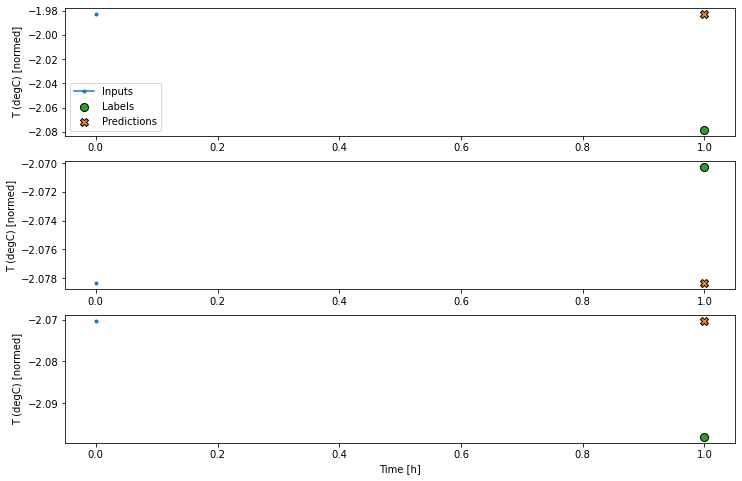

In [14]:
single_step_window.plot(baseline)

## Wide Window

In [15]:
wide_window = WindowGenerator(input_width=24, 
                              label_width=24, 
                              offset=1, 
                              label_columns=['T (degC)'], 
                              train_df=norm_train, 
                              val_df=norm_val, 
                              test_df=norm_test)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

success! finished making dataset
Shape of inputs = (32, 24, 19); shape of labels: (32, 24, 1)
************* Inside call *****************
shape of result = (32, 24)
shape of modified result = (32, 24, 1)
************* Inside call *****************
shape of result = (32, 24)
shape of modified result = (32, 24, 1)
************* Inside call *****************
shape of result = (32, 24)
shape of modified result = (32, 24, 1)


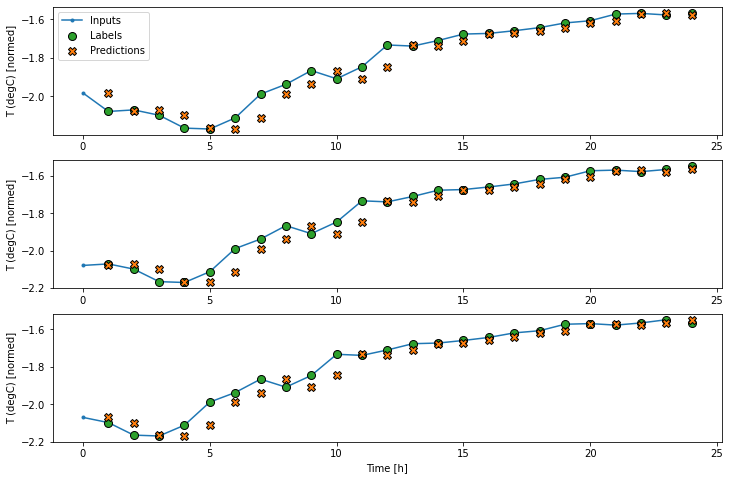

In [16]:
wide_window.plot(baseline)

# Compile and Fit Code

In [17]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    """
        patience: Number of epochs with no improvement after which training will be stopped.
        
        mode: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
        monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored 
        has stopped increasing; in "auto" mode, the direction is automatically inferred from 
        the name of the monitored quantity.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=patience, 
                                                      mode='min')
    # A metric is a function used to evaluate the model. During training, only the loss function is used. 
    model.compile(loss=tf.keras.losses.MeanSquaredError(), 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=[ tf.keras.metrics.MeanAbsoluteError()])
    history = model.fit(window.make_train, 
                        epochs=MAX_EPOCHS, 
                        validation_data=window.make_val, 
                        callbacks=[early_stopping])
    return history

# Model 1: Linear Model

In [18]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [19]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

success! finished making dataset
Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [20]:
hist = compile_and_fit(linear, single_step_window)

success! finished making dataset
success! finished making dataset
Epoch 1/20
1534/1534 [==============================] - 2s 931us/step - loss: 0.7247 - mean_absolute_error: 0.5363 - val_loss: 0.0224 - val_mean_absolute_error: 0.1144
Epoch 2/20
1534/1534 [==============================] - 1s 753us/step - loss: 0.0211 - mean_absolute_error: 0.1036 - val_loss: 0.0144 - val_mean_absolute_error: 0.0921
Epoch 3/20
1534/1534 [==============================] - 1s 764us/step - loss: 0.0125 - mean_absolute_error: 0.0820 - val_loss: 0.0120 - val_mean_absolute_error: 0.0846
Epoch 4/20
1534/1534 [==============================] - 1s 788us/step - loss: 0.0107 - mean_absolute_error: 0.0761 - val_loss: 0.0115 - val_mean_absolute_error: 0.0828
Epoch 5/20
1534/1534 [==============================] - 1s 750us/step - loss: 0.0102 - mean_absolute_error: 0.0742 - val_loss: 0.0113 - val_mean_absolute_error: 0.0822
Epoch 6/20
1534/1534 [==============================] - 1s 732us/step - loss: 0.0100 - mean_ab

In [21]:
val_performance['Linear'] = linear.evaluate(single_step_window.make_val)
performance['Linear'] = linear.evaluate(single_step_window.make_test)

success! finished making dataset
439/439 [==============================] - 0s 536us/step - loss: 0.0107 - mean_absolute_error: 0.0802
success! finished making dataset
220/220 [==============================] - 0s 530us/step - loss: 0.0099 - mean_absolute_error: 0.0759


In [22]:
performance

{'Baseline': [0.014162620529532433, 0.08516010642051697],
 'Linear': [0.009914997033774853, 0.07588980346918106]}

In [23]:
val_performance

{'Baseline': [0.012845635414123535, 0.07846628874540329],
 'Linear': [0.010695239529013634, 0.0802231878042221]}

### Linear Models on Wide Windows

The linear model can be called on batches of wide windows. Used this way, the model makes a set of independent predictions for each consecutive time step. The time axis acts like another batch axis. There are no interactions between the predictions at each time step.

In [24]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

success! finished making dataset
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [25]:
hist = compile_and_fit(linear, wide_window)

success! finished making dataset
success! finished making dataset
Epoch 1/20
1533/1533 [==============================] - 1s 803us/step - loss: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0108 - val_mean_absolute_error: 0.0805
Epoch 2/20
1533/1533 [==============================] - 1s 756us/step - loss: 0.0093 - mean_absolute_error: 0.0709 - val_loss: 0.0107 - val_mean_absolute_error: 0.0803
Epoch 3/20
1533/1533 [==============================] - 1s 759us/step - loss: 0.0093 - mean_absolute_error: 0.0708 - val_loss: 0.0107 - val_mean_absolute_error: 0.0802
Epoch 4/20
1533/1533 [==============================] - 1s 755us/step - loss: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0107 - val_mean_absolute_error: 0.0801
Epoch 5/20
1533/1533 [==============================] - 1s 754us/step - loss: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0107 - val_mean_absolute_error: 0.0801
Epoch 6/20
1533/1533 [==============================] - 1s 754us/step - loss: 0.0093 - mean_ab

In [26]:
val_performance['Linear (wide window)'] = linear.evaluate(wide_window.make_val)
performance['Linear (wide window)'] = linear.evaluate(wide_window.make_test)

success! finished making dataset
438/438 [==============================] - 0s 559us/step - loss: 0.0106 - mean_absolute_error: 0.0797
success! finished making dataset
219/219 [==============================] - 0s 554us/step - loss: 0.0097 - mean_absolute_error: 0.0750


In [27]:
performance

{'Baseline': [0.014162620529532433, 0.08516010642051697],
 'Linear': [0.009914997033774853, 0.07588980346918106],
 'Linear (wide window)': [0.009739954955875874, 0.07497740536928177]}

In [28]:
val_performance

{'Baseline': [0.012845635414123535, 0.07846628874540329],
 'Linear': [0.010695239529013634, 0.0802231878042221],
 'Linear (wide window)': [0.01058032177388668, 0.07972865551710129]}

success! finished making dataset
Shape of inputs = (32, 24, 19); shape of labels: (32, 24, 1)


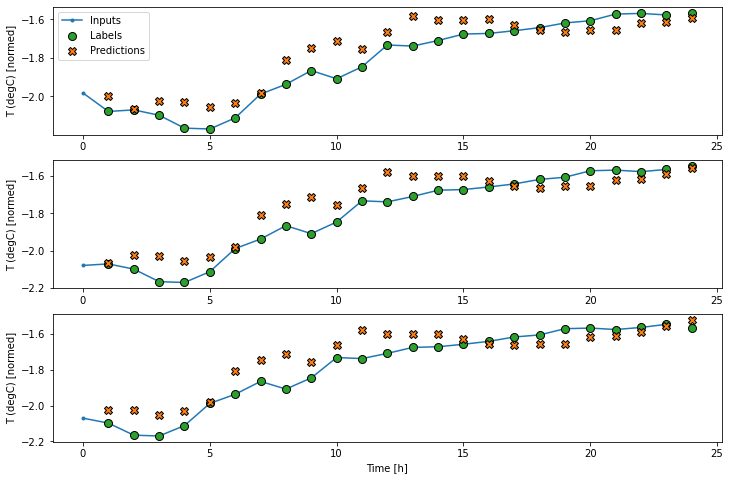

In [29]:
wide_window.plot(linear)

### Weights of the Linear Model

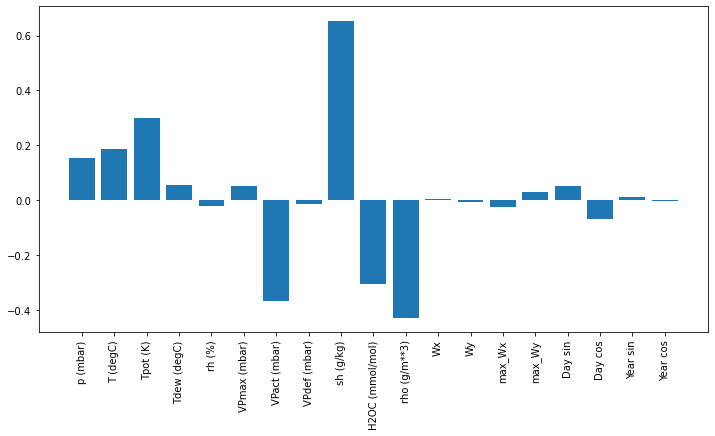

In [30]:
plt.bar(x = range(len(norm_train.columns)),
        height=linear.layers[0].kernel[:,0].numpy())

axis = plt.gca()

axis.set_xticks(range(len(norm_train.columns)))
_ = axis.set_xticklabels(norm_train.columns, rotation=90)

In [31]:
linear.layers[0].kernel[:,0].numpy()

array([ 0.15405364,  0.18624602,  0.29967982,  0.05316196, -0.02343134,
        0.0494624 , -0.36771932, -0.01625012,  0.6526929 , -0.30749568,
       -0.42924422,  0.00463158, -0.00745083, -0.02706073,  0.02936498,
        0.05067293, -0.06948106,  0.01157904, -0.00259013], dtype=float32)

In [32]:
linear.layers[0].get_weights()

[array([[ 0.15405364],
        [ 0.18624602],
        [ 0.29967982],
        [ 0.05316196],
        [-0.02343134],
        [ 0.0494624 ],
        [-0.36771932],
        [-0.01625012],
        [ 0.6526929 ],
        [-0.30749568],
        [-0.42924422],
        [ 0.00463158],
        [-0.00745083],
        [-0.02706073],
        [ 0.02936498],
        [ 0.05067293],
        [-0.06948106],
        [ 0.01157904],
        [-0.00259013]], dtype=float32),
 array([0.01495629], dtype=float32)]

# Model 2: Dense Single Step Model

In [33]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [34]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'), 
    tf.keras.layers.Dense(units=64, activation='relu'), 
    tf.keras.layers.Dense(units=1)])

history = compile_and_fit(dense, single_step_window)
val_performance['Dense (single step)'] = dense.evaluate(single_step_window.make_val)
performance['Dense (single step)'] = dense.evaluate(single_step_window.make_test)

success! finished making dataset
success! finished making dataset
Epoch 1/20
1534/1534 [==============================] - 2s 950us/step - loss: 0.5059 - mean_absolute_error: 0.3045 - val_loss: 0.0151 - val_mean_absolute_error: 0.0926
Epoch 2/20
1534/1534 [==============================] - 1s 918us/step - loss: 0.0155 - mean_absolute_error: 0.0922 - val_loss: 0.0154 - val_mean_absolute_error: 0.0946
Epoch 3/20
1534/1534 [==============================] - 1s 890us/step - loss: 0.0145 - mean_absolute_error: 0.0904 - val_loss: 0.0143 - val_mean_absolute_error: 0.0903
Epoch 4/20
1534/1534 [==============================] - 1s 884us/step - loss: 0.0112 - mean_absolute_error: 0.0796 - val_loss: 0.0126 - val_mean_absolute_error: 0.0849
Epoch 5/20
1534/1534 [==============================] - 1s 881us/step - loss: 0.0108 - mean_absolute_error: 0.0770 - val_loss: 0.0123 - val_mean_absolute_error: 0.0835
Epoch 6/20
1534/1534 [==============================] - 1s 900us/step - loss: 0.0100 - mean_ab

In [35]:
performance

{'Baseline': [0.014162620529532433, 0.08516010642051697],
 'Linear': [0.009914997033774853, 0.07588980346918106],
 'Linear (wide window)': [0.009739954955875874, 0.07497740536928177],
 'Dense (single step)': [0.012465416453778744, 0.084329754114151]}

# Model 3: Dense Multistep Input, Single Output


In [36]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH, 
    label_width=1, 
    offset=1, 
    label_columns=['T (degC)'],
    train_df=norm_train,
    val_df=norm_val,
    test_df=norm_test
)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

success! finished making dataset
Shape of inputs = (32, 3, 19); shape of labels: (32, 1, 1)


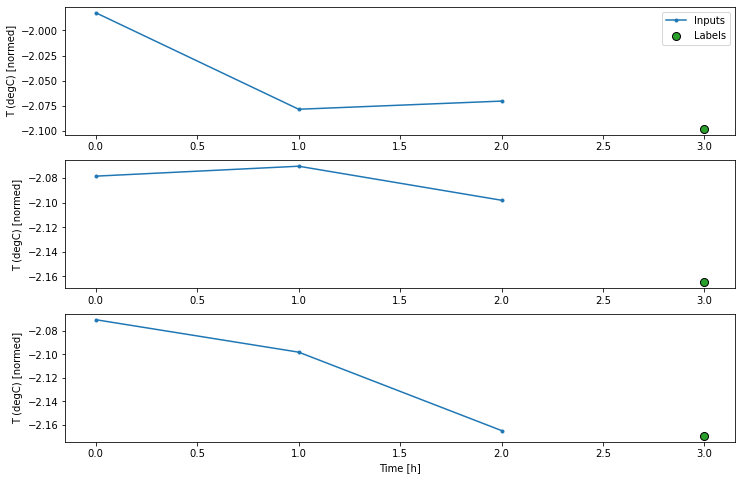

In [37]:
conv_window.plot()

In [38]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, 1]),
])

In [39]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


success! finished making dataset
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [40]:
multi_step_dense.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (32, 57)                  0         
_________________________________________________________________
dense_4 (Dense)              (32, 32)                  1856      
_________________________________________________________________
dense_5 (Dense)              (32, 32)                  1056      
_________________________________________________________________
dense_6 (Dense)              (32, 1)                   33        
_________________________________________________________________
reshape (Reshape)            (32, 1, 1)                0         
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = compile_and_fit(multi_step_dense, conv_window)
val_performance['Dense (multi step)'] = multi_step_dense.evaluate(conv_window.make_val)
performance['Dense (multi step)'] = multi_step_dense.evaluate(conv_window.make_test)

success! finished making dataset
success! finished making dataset
Epoch 1/20
1534/1534 [==============================] - 2s 906us/step - loss: 0.2111 - mean_absolute_error: 0.2434 - val_loss: 0.0221 - val_mean_absolute_error: 0.1125
Epoch 2/20
1534/1534 [==============================] - 1s 865us/step - loss: 0.0210 - mean_absolute_error: 0.1071 - val_loss: 0.0174 - val_mean_absolute_error: 0.0997
Epoch 3/20
1534/1534 [==============================] - 1s 873us/step - loss: 0.0161 - mean_absolute_error: 0.0943 - val_loss: 0.0152 - val_mean_absolute_error: 0.0934
Epoch 4/20
1534/1534 [==============================] - 1s 874us/step - loss: 0.0142 - mean_absolute_error: 0.0881 - val_loss: 0.0139 - val_mean_absolute_error: 0.0892
Epoch 5/20
1534/1534 [==============================] - 1s 875us/step - loss: 0.0110 - mean_absolute_error: 0.0777 - val_loss: 0.0131 - val_mean_absolute_error: 0.0857
Epoch 6/20
1534/1534 [==============================] - 1s 854us/step - loss: 0.0102 - mean_ab

In [42]:
performance

{'Baseline': [0.014162620529532433, 0.08516010642051697],
 'Linear': [0.009914997033774853, 0.07588980346918106],
 'Linear (wide window)': [0.009739954955875874, 0.07497740536928177],
 'Dense (single step)': [0.012465416453778744, 0.084329754114151],
 'Dense (multi step)': [0.010099760256707668, 0.07588214427232742]}

success! finished making dataset
Shape of inputs = (32, 3, 19); shape of labels: (32, 1, 1)


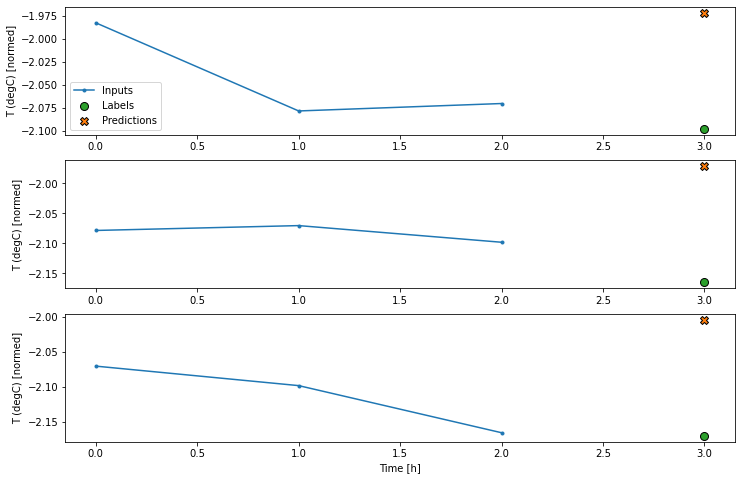

In [43]:
conv_window.plot(multi_step_dense)

# Conv Net Model 

In [44]:
CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, 
                           kernel_size=(CONV_WIDTH, ), 
                           activation='relu'), 
    tf.keras.layers.Dense(units=32, activation='relu'), 
    tf.keras.layers.Dense(units=1)])

## Explanation

The `filters` refers to the number of feature maps. In this case, we have 32 feature maps after the input layer. The `kernel_size` in this `1D` layer is $(3, )$. This means that each neuron in a feature map has a local receptive field of size $3 \times 19$ (there are 19 features). Thus the number of parameters for each feature map is:
$$
    3 \times 19 + 1 = 58 \quad (+ 1 \text{ for the bias}).
$$
Since there are $32$ feature maps, there are a total of $58 \times 32 = 1856$ parameters in the first convolutional layer.

In [45]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [46]:
conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (32, 1, 32)               1856      
_________________________________________________________________
dense_7 (Dense)              (32, 1, 32)               1056      
_________________________________________________________________
dense_8 (Dense)              (32, 1, 1)                33        
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = compile_and_fit(conv_model, conv_window)
val_performance['CNN (multi step)'] = conv_model.evaluate(conv_window.make_val)
performance['CNN (multi step)'] = conv_model.evaluate(conv_window.make_test)

success! finished making dataset
success! finished making dataset
Epoch 1/20
1534/1534 [==============================] - 2s 951us/step - loss: 0.1190 - mean_absolute_error: 0.2146 - val_loss: 0.0168 - val_mean_absolute_error: 0.0990
Epoch 2/20
1534/1534 [==============================] - 1s 881us/step - loss: 0.0175 - mean_absolute_error: 0.0998 - val_loss: 0.0200 - val_mean_absolute_error: 0.1089
Epoch 3/20
1534/1534 [==============================] - 1s 895us/step - loss: 0.0147 - mean_absolute_error: 0.0910 - val_loss: 0.0123 - val_mean_absolute_error: 0.0845
Epoch 4/20
1534/1534 [==============================] - 1s 901us/step - loss: 0.0120 - mean_absolute_error: 0.0821 - val_loss: 0.0126 - val_mean_absolute_error: 0.0862
Epoch 5/20
1534/1534 [==============================] - 1s 911us/step - loss: 0.0113 - mean_absolute_error: 0.0793 - val_loss: 0.0119 - val_mean_absolute_error: 0.0831
Epoch 6/20
1534/1534 [==============================] - 1s 905us/step - loss: 0.0107 - mean_ab

In [48]:
performance

{'Baseline': [0.014162620529532433, 0.08516010642051697],
 'Linear': [0.009914997033774853, 0.07588980346918106],
 'Linear (wide window)': [0.009739954955875874, 0.07497740536928177],
 'Dense (single step)': [0.012465416453778744, 0.084329754114151],
 'Dense (multi step)': [0.010099760256707668, 0.07588214427232742],
 'CNN (multi step)': [0.010892162099480629, 0.07905050367116928]}

In [49]:
val_performance

{'Baseline': [0.012845635414123535, 0.07846628874540329],
 'Linear': [0.010695239529013634, 0.0802231878042221],
 'Linear (wide window)': [0.01058032177388668, 0.07972865551710129],
 'Dense (single step)': [0.013564972206950188, 0.08882078528404236],
 'Dense (multi step)': [0.010326189920306206, 0.07650215178728104],
 'CNN (multi step)': [0.01134568639099598, 0.08084876090288162]}

# Conv Net Wider Windows

In [50]:
CONV_WIDTH = 6
conv_window_II = WindowGenerator(
    input_width=CONV_WIDTH, 
    label_width=1, 
    offset=1, 
    label_columns=['T (degC)'],
    train_df=norm_train,
    val_df=norm_val,
    test_df=norm_test
)

conv_window_II

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [51]:
conv_model_II = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, 
                           kernel_size=(CONV_WIDTH, ), 
                           activation='relu'), 
    tf.keras.layers.Dense(units=32, activation='relu'), 
    tf.keras.layers.Dense(units=1)])

In [52]:
print("Conv model II on `conv_window` II")
print('Input shape:', conv_window_II.example[0].shape)
print('Output shape:', conv_model_II(conv_window_II.example[0]).shape)

Conv model II on `conv_window` II
success! finished making dataset
Input shape: (32, 6, 19)
Output shape: (32, 1, 1)


In [53]:
conv_model_II.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (32, 1, 32)               3680      
_________________________________________________________________
dense_9 (Dense)              (32, 1, 32)               1056      
_________________________________________________________________
dense_10 (Dense)             (32, 1, 1)                33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = compile_and_fit(conv_model_II, conv_window_II)
val_performance['CNN II(multi step)'] = conv_model_II.evaluate(conv_window_II.make_val)
performance['CNN II (multi step)'] = conv_model_II.evaluate(conv_window_II.make_test)

success! finished making dataset
success! finished making dataset
Epoch 1/20
1534/1534 [==============================] - 2s 974us/step - loss: 0.0931 - mean_absolute_error: 0.2122 - val_loss: 0.0255 - val_mean_absolute_error: 0.1234
Epoch 2/20
1534/1534 [==============================] - 1s 879us/step - loss: 0.0220 - mean_absolute_error: 0.1111 - val_loss: 0.0140 - val_mean_absolute_error: 0.0924
Epoch 3/20
1534/1534 [==============================] - 1s 909us/step - loss: 0.0153 - mean_absolute_error: 0.0926 - val_loss: 0.0130 - val_mean_absolute_error: 0.0886
Epoch 4/20
1534/1534 [==============================] - 1s 875us/step - loss: 0.0131 - mean_absolute_error: 0.0858 - val_loss: 0.0125 - val_mean_absolute_error: 0.0865
Epoch 5/20
1534/1534 [==============================] - 1s 908us/step - loss: 0.0122 - mean_absolute_error: 0.0825 - val_loss: 0.0113 - val_mean_absolute_error: 0.0809
Epoch 6/20
1534/1534 [==============================] - 1s 915us/step - loss: 0.0116 - mean_ab

In [55]:
performance

{'Baseline': [0.014162620529532433, 0.08516010642051697],
 'Linear': [0.009914997033774853, 0.07588980346918106],
 'Linear (wide window)': [0.009739954955875874, 0.07497740536928177],
 'Dense (single step)': [0.012465416453778744, 0.084329754114151],
 'Dense (multi step)': [0.010099760256707668, 0.07588214427232742],
 'CNN (multi step)': [0.010892162099480629, 0.07905050367116928],
 'CNN II (multi step)': [0.009499802254140377, 0.0737469270825386]}

In [56]:
CONV_WIDTH = 24
conv_window_III = WindowGenerator(
    input_width=CONV_WIDTH, 
    label_width=1, 
    offset=1, 
    label_columns=['T (degC)'],
    train_df=norm_train,
    val_df=norm_val,
    test_df=norm_test
)

conv_window_III

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']

In [57]:
conv_model_III = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, 
                           kernel_size=(CONV_WIDTH, ), 
                           activation='relu'), 
    tf.keras.layers.Dense(units=32, activation='relu'), 
    tf.keras.layers.Dense(units=1)])

In [58]:
print("Conv model III on `conv_window` III")
print('Input shape:', conv_window_III.example[0].shape)
print('Output shape:', conv_model_III(conv_window_III.example[0]).shape)

Conv model III on `conv_window` III
success! finished making dataset
Input shape: (32, 24, 19)
Output shape: (32, 1, 1)


In [59]:
history = compile_and_fit(conv_model_III, conv_window_III)
val_performance['CNN III(multi step)'] = conv_model_III.evaluate(conv_window_III.make_val)
performance['CNN III (multi step)'] = conv_model_III.evaluate(conv_window_III.make_test)

success! finished making dataset
success! finished making dataset
Epoch 1/20
1533/1533 [==============================] - 2s 1ms/step - loss: 0.1554 - mean_absolute_error: 0.2923 - val_loss: 0.0479 - val_mean_absolute_error: 0.1741
Epoch 2/20
1533/1533 [==============================] - 2s 987us/step - loss: 0.0498 - mean_absolute_error: 0.1696 - val_loss: 0.0336 - val_mean_absolute_error: 0.1456
Epoch 3/20
1533/1533 [==============================] - 2s 993us/step - loss: 0.0411 - mean_absolute_error: 0.1533 - val_loss: 0.0290 - val_mean_absolute_error: 0.1321
Epoch 4/20
1533/1533 [==============================] - 2s 999us/step - loss: 0.0322 - mean_absolute_error: 0.1328 - val_loss: 0.0282 - val_mean_absolute_error: 0.1322
Epoch 5/20
1533/1533 [==============================] - 1s 965us/step - loss: 0.0354 - mean_absolute_error: 0.1389 - val_loss: 0.0174 - val_mean_absolute_error: 0.1030
Epoch 6/20
1533/1533 [==============================] - 2s 994us/step - loss: 0.0252 - mean_abso

In [60]:
performance

{'Baseline': [0.014162620529532433, 0.08516010642051697],
 'Linear': [0.009914997033774853, 0.07588980346918106],
 'Linear (wide window)': [0.009739954955875874, 0.07497740536928177],
 'Dense (single step)': [0.012465416453778744, 0.084329754114151],
 'Dense (multi step)': [0.010099760256707668, 0.07588214427232742],
 'CNN (multi step)': [0.010892162099480629, 0.07905050367116928],
 'CNN II (multi step)': [0.009499802254140377, 0.0737469270825386],
 'CNN III (multi step)': [0.05015571787953377, 0.1754286289215088]}

# LSTMs

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [63]:
wide_window = WindowGenerator(input_width=24, 
                              label_width=24, 
                              offset=1, 
                              label_columns=['T (degC)'], 
                              train_df=norm_train, 
                              val_df=norm_val, 
                              test_df=norm_test)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [64]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.make_val)
performance['LSTM'] = lstm_model.evaluate(wide_window.make_test, verbose=0)

success! finished making dataset
success! finished making dataset
Epoch 1/20
1533/1533 [==============================] - 11s 6ms/step - loss: 0.1872 - mean_absolute_error: 0.2471 - val_loss: 0.0150 - val_mean_absolute_error: 0.0915
Epoch 2/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0216 - mean_absolute_error: 0.1029 - val_loss: 0.0100 - val_mean_absolute_error: 0.0741
Epoch 3/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0122 - mean_absolute_error: 0.0795 - val_loss: 0.0092 - val_mean_absolute_error: 0.0710
Epoch 4/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0101 - mean_absolute_error: 0.0726 - val_loss: 0.0091 - val_mean_absolute_error: 0.0706
Epoch 5/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0093 - mean_absolute_error: 0.0696 - val_loss: 0.0095 - val_mean_absolute_error: 0.0727
Epoch 6/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0088 - mean_absolute_erro

success! finished making dataset
Shape of inputs = (32, 24, 19); shape of labels: (32, 24, 1)


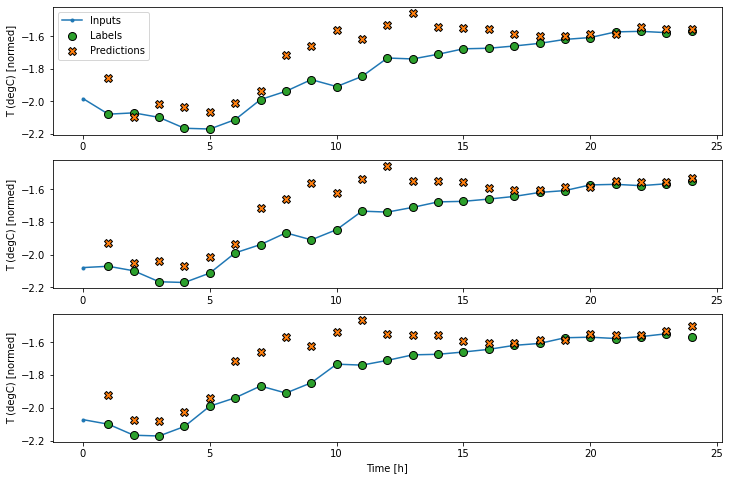

In [65]:
wide_window.plot(lstm_model)

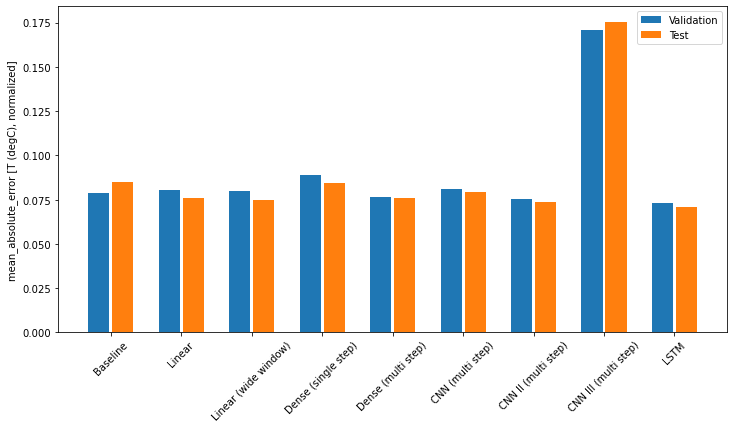

In [66]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [67]:
for name, value in performance.items():
    print(f'{name:20s}: {value[1]:0.4f}')

Baseline            : 0.0852
Linear              : 0.0759
Linear (wide window): 0.0750
Dense (single step) : 0.0843
Dense (multi step)  : 0.0759
CNN (multi step)    : 0.0791
CNN II (multi step) : 0.0737
CNN III (multi step): 0.1754
LSTM                : 0.0710
